In [1]:
!nvidia-smi

Mon Jul 20 18:45:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.48       Driver Version: 451.48       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   81C    P8    15W /  N/A |   1215MiB /  8192MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
# !pip install pytorch_transformers

In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [4]:
df = pd.read_csv("reviews.csv")

In [5]:
print (df.shape)
df.head(2)

(16054, 12)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...,Mad Scientist,https://lh3.googleusercontent.com/-kIZF4kMt6yY...,"Unable to register with an email. Clicking""con...",1,76,5.2.0.9,2020-07-10 23:29:22,We are unaware of any issues with signing in t...,2020-07-12 13:32:19,most_relevant,com.anydo
1,gp:AOqpTOGG5EdQ69VnyUoJ2bJ4jB_hWqNeLh9nZ-ULOVz...,Sergey P,https://lh3.googleusercontent.com/a-/AOh14GgVZ...,Any.Forget... Had an instance of daily repeati...,1,12,5.2.0.9,2020-07-08 15:07:48,Our team will be happy to look into this issue...,2020-07-09 13:49:41,most_relevant,com.anydo


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16054 entries, 0 to 16053
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16054 non-null  object
 1   userName              16054 non-null  object
 2   userImage             16054 non-null  object
 3   content               16054 non-null  object
 4   score                 16054 non-null  int64 
 5   thumbsUpCount         16054 non-null  int64 
 6   reviewCreatedVersion  13779 non-null  object
 7   at                    16054 non-null  object
 8   replyContent          7896 non-null   object
 9   repliedAt             7896 non-null   object
 10  sortOrder             16054 non-null  object
 11  appId                 16054 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


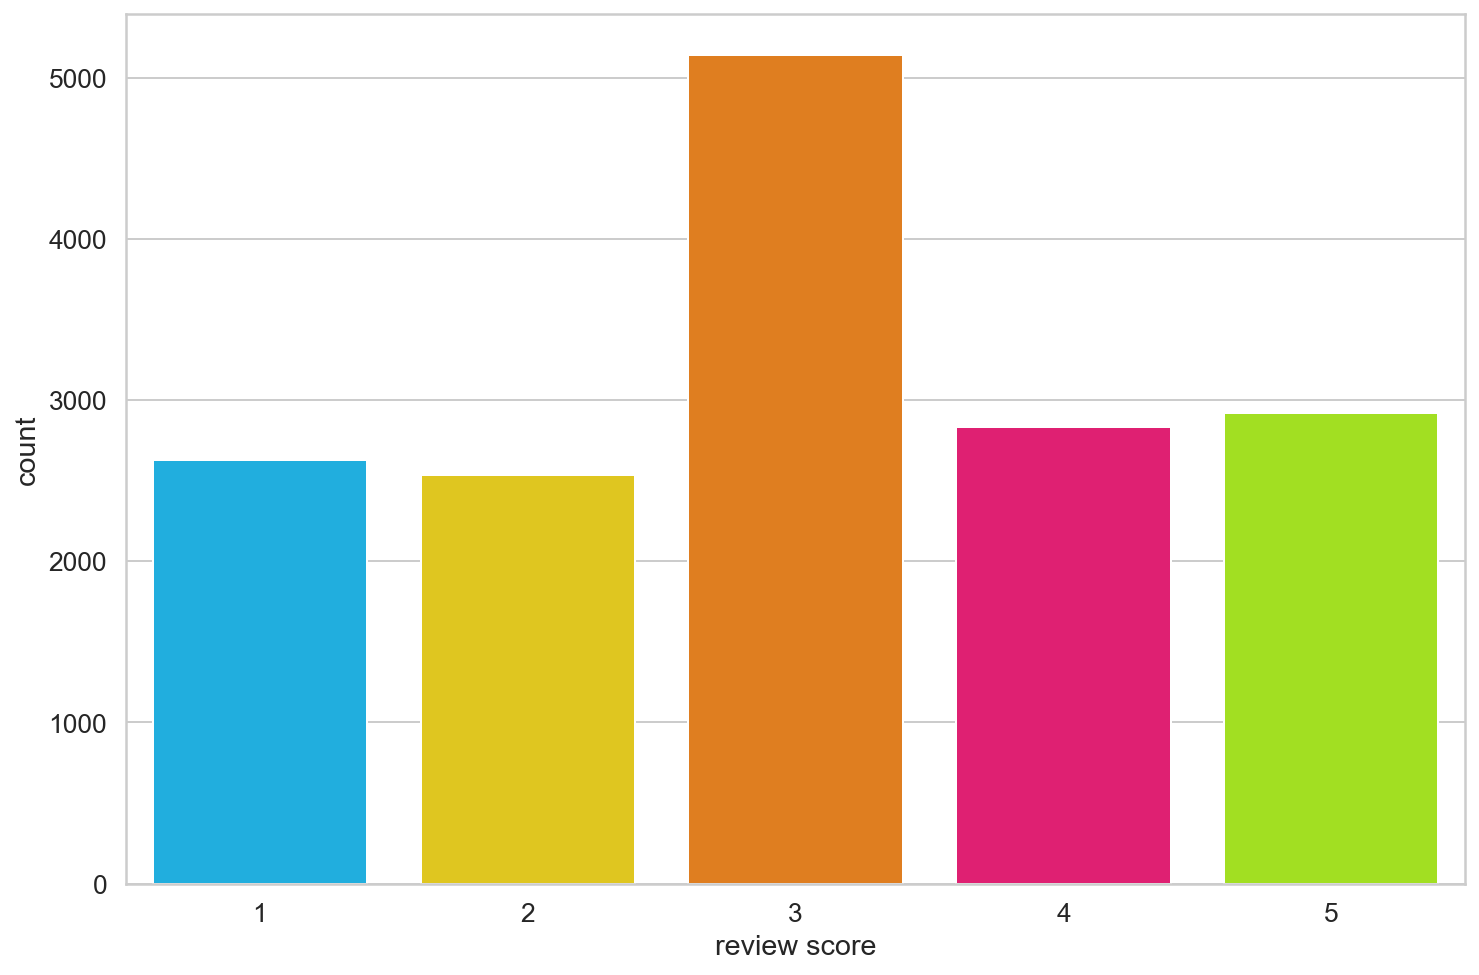

In [7]:
sns.countplot(df.score)
plt.xlabel('review score');

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...,Mad Scientist,https://lh3.googleusercontent.com/-kIZF4kMt6yY...,"Unable to register with an email. Clicking""con...",1,76,5.2.0.9,2020-07-10 23:29:22,We are unaware of any issues with signing in t...,2020-07-12 13:32:19,most_relevant,com.anydo,0
1,gp:AOqpTOGG5EdQ69VnyUoJ2bJ4jB_hWqNeLh9nZ-ULOVz...,Sergey P,https://lh3.googleusercontent.com/a-/AOh14GgVZ...,Any.Forget... Had an instance of daily repeati...,1,12,5.2.0.9,2020-07-08 15:07:48,Our team will be happy to look into this issue...,2020-07-09 13:49:41,most_relevant,com.anydo,0


In [10]:
df.sentiment.value_counts()

2    5750
0    5164
1    5140
Name: sentiment, dtype: int64

In [11]:
class_names = ['negative', 'neutral', 'positive']

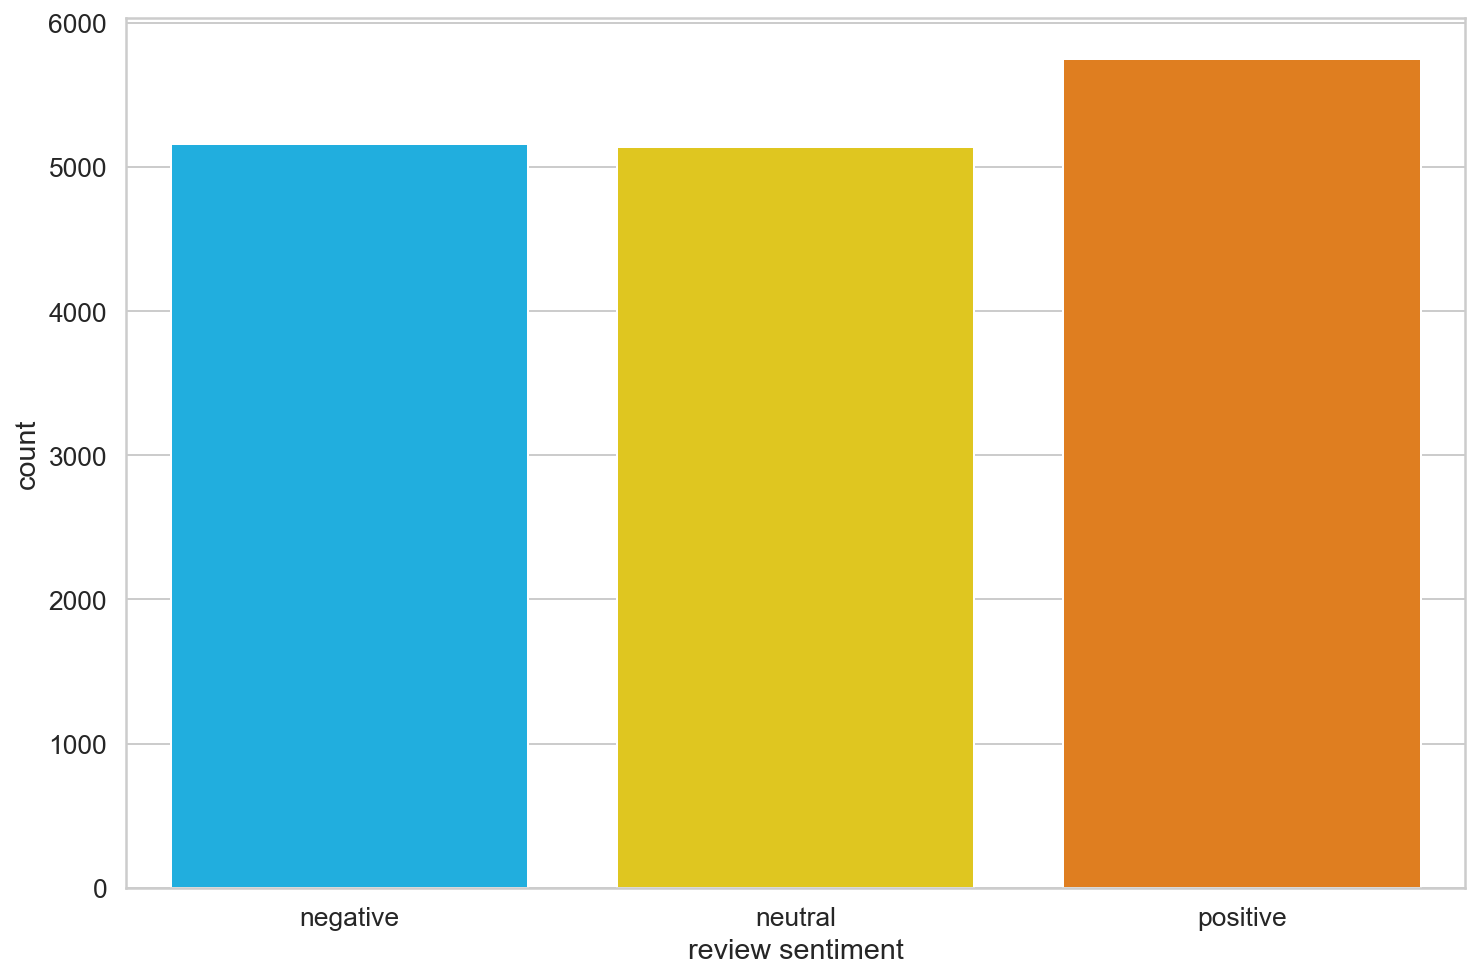

In [12]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [13]:
sentences = [sentence + " [SEP] [CLS]" for sentence in df.content]
labels = df.sentiment

In [14]:
sentences[0]

'Unable to register with an email. Clicking"continue with email" will just take you to a login page. Complete waste of time. I searched them first three pages of Google for a solution and found nothing. Found no solution on their help section. I don\'t want to register with Facebook or Google. If you include a feature, make sure it actually works. [SEP] [CLS]'

In [15]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [16]:

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁unable', '▁to', '▁register', '▁with', '▁an', '▁email', '.', '▁clicking', '"', 'continue', '▁with', '▁email', '"', '▁will', '▁just', '▁take', '▁you', '▁to', '▁a', '▁login', '▁page', '.', '▁complete', '▁waste', '▁of', '▁time', '.', '▁', 'i', '▁searched', '▁them', '▁first', '▁three', '▁pages', '▁of', '▁', 'google', '▁for', '▁a', '▁solution', '▁and', '▁found', '▁nothing', '.', '▁found', '▁no', '▁solution', '▁on', '▁their', '▁help', '▁section', '.', '▁', 'i', '▁don', "'", 't', '▁want', '▁to', '▁register', '▁with', '▁face', 'book', '▁or', '▁', 'google', '.', '▁if', '▁you', '▁include', '▁a', '▁feature', ',', '▁make', '▁sure', '▁it', '▁actually', '▁works', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [17]:
tokenizer.tokenize("Rahul")

['▁', 'rah', 'ul']

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

In [19]:
MAX_LEN = 128


In [20]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


In [21]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [22]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [23]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
16049    2
16050    2
16051    2
16052    2
16053    2
Name: sentiment, Length: 16054, dtype: int64

In [24]:
input_ids

array([[2806,   22, 4081, ...,    0,    0,    0],
       [ 124,    9, 1383, ...,    0,    0,    0],
       [  36, 1021, 4968, ...,    0,    0,    0],
       ...,
       [ 312,  625, 4145, ...,    0,    0,    0],
       [  52,   27,   18, ...,    0,    0,    0],
       [2712, 4145,   23, ...,    0,    0,    0]])

In [25]:
# train_labels

In [26]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=56, test_size=0.2)

In [27]:
# Convert all of our data into torch tensors, the required datatype for our model
# torch.tensor(train).to(torch.int64)
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)
train_labels = torch.tensor(train_labels.to_numpy()).to(torch.int64)
validation_labels = torch.tensor(validation_labels.to_numpy()).to(torch.int64)
train_masks = torch.tensor(train_masks).to(torch.int64).to(torch.int64)
validation_masks = torch.tensor(validation_masks).to(torch.int64)

In [28]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [29]:
import torch
from pytorch_transformers import XLNetConfig
from pytorch_transformers import XLNetTokenizer
from pytorch_transformers import XLNetForSequenceClassification
from transformers import XLNetConfig, XLNetModel

In [30]:
import torch

from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)

model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias','gamma','beta']
optimizer_grouped_parameters = [
    {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate':0.01},
    {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate':0.0}
]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [31]:
# # Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
# # model.cuda()

In [32]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [33]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [34]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
# # Store our loss and accuracy for plotting
# train_loss_set = []

# # Number of training epochs (authors recommend between 2 and 4)
# epochs = 4

# # trange is a tqdm wrapper around the normal python range
# for _ in trange(epochs, desc="Epoch"):
  
#   # Training
  
#   # Set our model to training mode (as opposed to evaluation mode)
#   model.train()
  
#   # Tracking variables
#   tr_loss = 0
#   nb_tr_examples, nb_tr_steps = 0, 0
  
#   # Train the data for one epoch
#   for step, batch in enumerate(train_dataloader):
#     # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
#     # Unpack the inputs from our dataloader
#     b_input_ids, b_input_mask, b_labels = batch
#     # Clear out the gradients (by default they accumulate)
#     optimizer.zero_grad()
#     # Forward pass
#     outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#     loss = outputs[0]
#     logits = outputs[1]
#     train_loss_set.append(loss.item())    
#     # Backward pass
#     loss.backward()
#     # Update parameters and take a step using the computed gradient
#     optimizer.step()
    
    
#     # Update tracking variables
#     tr_loss += loss.item()
#     nb_tr_examples += b_input_ids.size(0)
#     nb_tr_steps += 1

#   print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
#   # Validation

#   # Put model in evaluation mode to evaluate loss on the validation set
#   model.eval()

#   # Tracking variables 
#   eval_loss, eval_accuracy = 0, 0
#   nb_eval_steps, nb_eval_examples = 0, 0

#   # Evaluate data for one epoch
#   for batch in validation_dataloader:
#     # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
#     # Unpack the inputs from our dataloader
#     b_input_ids, b_input_mask, b_labels = batch
#     # Telling the model not to compute or store gradients, saving memory and speeding up validation
#     with torch.no_grad():
#       # Forward pass, calculate logit predictions
#       output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
#       logits = output[0]
    
#     # Move logits and labels to CPU
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()

#     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
#     eval_accuracy += tmp_eval_accuracy
#     nb_eval_steps += 1

#   print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

In [36]:
# ! pip install pytorchtools

In [37]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [38]:
import time
start = time.time()

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 19

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


##################
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in train_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("train  Accuracy: {}".format(eval_accuracy/nb_eval_steps))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch:   0%|                                                                                    | 0/19 [00:00<?, ?it/s]..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 0.7397449372120545
Validation Accuracy: 0.6794436906377205


Epoch:   5%|███▊                                                                     | 1/19 [09:08<2:44:32, 548.48s/it]

train  Accuracy: 0.7211663647684818
Train loss: 0.5693288857063944
Validation Accuracy: 0.7715117593848937


Epoch:  11%|███████▋                                                                 | 2/19 [18:32<2:36:44, 553.19s/it]

train  Accuracy: 0.8715824182044606
Train loss: 0.4297315338962847
Validation Accuracy: 0.7902815468113975


Epoch:  16%|███████████▌                                                             | 3/19 [28:01<2:28:46, 557.91s/it]

train  Accuracy: 0.9172704630363411
Train loss: 0.3033672651069547
Validation Accuracy: 0.8204432383536862


Epoch:  21%|███████████████▎                                                         | 4/19 [37:31<2:20:24, 561.62s/it]

train  Accuracy: 0.9532222914072229
Train loss: 0.21309516773759798
Validation Accuracy: 0.8324287652645861


Epoch:  26%|███████████████████▏                                                     | 5/19 [47:03<2:11:42, 564.50s/it]

train  Accuracy: 0.9700767010075851
Train loss: 0.160548553506323
Validation Accuracy: 0.8313263229308006


Epoch:  32%|███████████████████████                                                  | 6/19 [56:56<2:04:11, 573.18s/it]

train  Accuracy: 0.9626825540586437
Train loss: 0.13815111598721327
Validation Accuracy: 0.8325701040253279


Epoch:  37%|██████████████████████████▏                                            | 7/19 [1:06:51<1:55:56, 579.68s/it]

train  Accuracy: 0.9712017434620175
Train loss: 0.11236678554234587
Validation Accuracy: 0.8335029398462234


Epoch:  42%|█████████████████████████████▉                                         | 8/19 [1:17:26<1:49:21, 596.46s/it]

train  Accuracy: 0.974859900373599
Train loss: 0.09871213229032115
Validation Accuracy: 0.8412765716870194


Epoch:  47%|█████████████████████████████████▋                                     | 9/19 [1:27:32<1:39:51, 599.17s/it]

train  Accuracy: 0.974279689799615
Train loss: 0.09108958809936922
Validation Accuracy: 0.8411069651741293


Epoch:  53%|████████████████████████████████████▊                                 | 10/19 [1:37:07<1:28:46, 591.88s/it]

train  Accuracy: 0.9822186686290049
Train loss: 0.08470341704256953
Validation Accuracy: 0.8474954771596562


Epoch:  58%|████████████████████████████████████████▌                             | 11/19 [1:46:47<1:18:26, 588.37s/it]

train  Accuracy: 0.9855230386052304
Train loss: 0.08115547305787188
Validation Accuracy: 0.8426899592944369


Epoch:  63%|████████████████████████████████████████████▏                         | 12/19 [1:56:17<1:07:59, 582.80s/it]

train  Accuracy: 0.9826432129514321
Train loss: 0.07237026514543468
Validation Accuracy: 0.8378561736770692


Epoch:  68%|█████████████████████████████████████████████████▎                      | 13/19 [2:05:48<57:55, 579.25s/it]

train  Accuracy: 0.9825653798256538
Train loss: 0.07309213096964849
Validation Accuracy: 0.8398914518317503


Epoch:  74%|█████████████████████████████████████████████████████                   | 14/19 [2:15:29<48:19, 579.89s/it]

train  Accuracy: 0.9833437110834371
Train loss: 0.06562011502451202
Validation Accuracy: 0.8471845318860244


Epoch:  79%|████████████████████████████████████████████████████████▊               | 15/19 [2:25:07<38:36, 579.15s/it]

train  Accuracy: 0.9840088305219065
Train loss: 0.0699938334847057
Validation Accuracy: 0.8534317051108096


Epoch:  84%|████████████████████████████████████████████████████████████▋           | 16/19 [2:34:40<28:52, 577.54s/it]

train  Accuracy: 0.9841220423412205
Train loss: 0.06325131859444778
Validation Accuracy: 0.8509158751696065


Epoch:  89%|████████████████████████████████████████████████████████████████▍       | 17/19 [2:44:39<19:27, 583.94s/it]

train  Accuracy: 0.9856008717310087
Train loss: 0.058686837780864615
Validation Accuracy: 0.844075079149706


Epoch:  95%|████████████████████████████████████████████████████████████████████▏   | 18/19 [2:54:06<09:38, 578.77s/it]

train  Accuracy: 0.9868108230499264
Train loss: 0.06129130926261543
Validation Accuracy: 0.8498417005879693


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [3:03:28<00:00, 579.40s/it]

train  Accuracy: 0.9849782067247821
03:03:28.51


###### 

In [39]:
torch.save(model.state_dict(), 'model_without_language_model_epochs_25.ckpt')


In [40]:
# torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')
# Test the model

with torch.no_grad():
    correct = 0
    total = 0
    actual_labels = []
#     pred_labels = []
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      prediction_prob = torch.softmax(outputs[0],dim=1)
      actual_labels.append([b_labels, prediction,prediction_prob])
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()

In [55]:
# b_input_ids

In [41]:
print('Test Accuracy of the model on vla data is: {} %'.format(100 * correct / total))


Test Accuracy of the model on vla data is: 84.98909996885705 %


In [56]:
# actual_labels

In [43]:
actual_labels[0][0]

tensor([1, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')

In [44]:
actual_labels[0][0].cpu().numpy().tolist()

[1, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1]

In [45]:
actual_list = []
pred = []
pred_prob = []
for i in range(len(actual_labels)):
    actual_list.extend(actual_labels[i][0].cpu().numpy().tolist())
    pred.extend(actual_labels[i][1].cpu().numpy().tolist())
    pred_prob.extend(actual_labels[i][2].cpu().numpy().tolist())
    

In [51]:
# pred_prob

In [54]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(actual_list, pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print (cm)
print ("precision = ", precision)
print ("recall = ", recall)

[[ 896   76   31]
 [ 148  793   93]
 [  43   91 1040]]
precision =  [0.82428703 0.82604167 0.89347079]
recall =  [0.89332004 0.76692456 0.88586031]


In [47]:
from sklearn.metrics import accuracy_score


In [48]:
accuracy_score(actual_list, pred)


0.8498909996885705

In [49]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(actual_list, pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print ("product_type_precision = ", precision)
print ("product_type_recall = ", recall)

product_type_precision =  [0.82428703 0.82604167 0.89347079]
product_type_recall =  [0.89332004 0.76692456 0.88586031]


In [50]:
from sklearn.metrics import classification_report

print(classification_report(actual_list, pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1003
           1       0.83      0.77      0.80      1034
           2       0.89      0.89      0.89      1174

    accuracy                           0.85      3211
   macro avg       0.85      0.85      0.85      3211
weighted avg       0.85      0.85      0.85      3211



In [57]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [62]:
y = label_binarize(actual_list, classes=[0, 1, 2])
y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [67]:
y[:, i]

array([0, 0, 0, ..., 1, 1, 0])

In [75]:
np.array(pred_prob)[:, i]

array([1.70482366e-04, 1.22596964e-03, 9.55611765e-02, ...,
       9.99934793e-01, 9.99927044e-01, 7.34955320e-05])

In [72]:
# pred_prob[:, i]
pred_prob[:1]

[[0.0001704823662294075, 0.9997971653938293, 3.242391539970413e-05]]

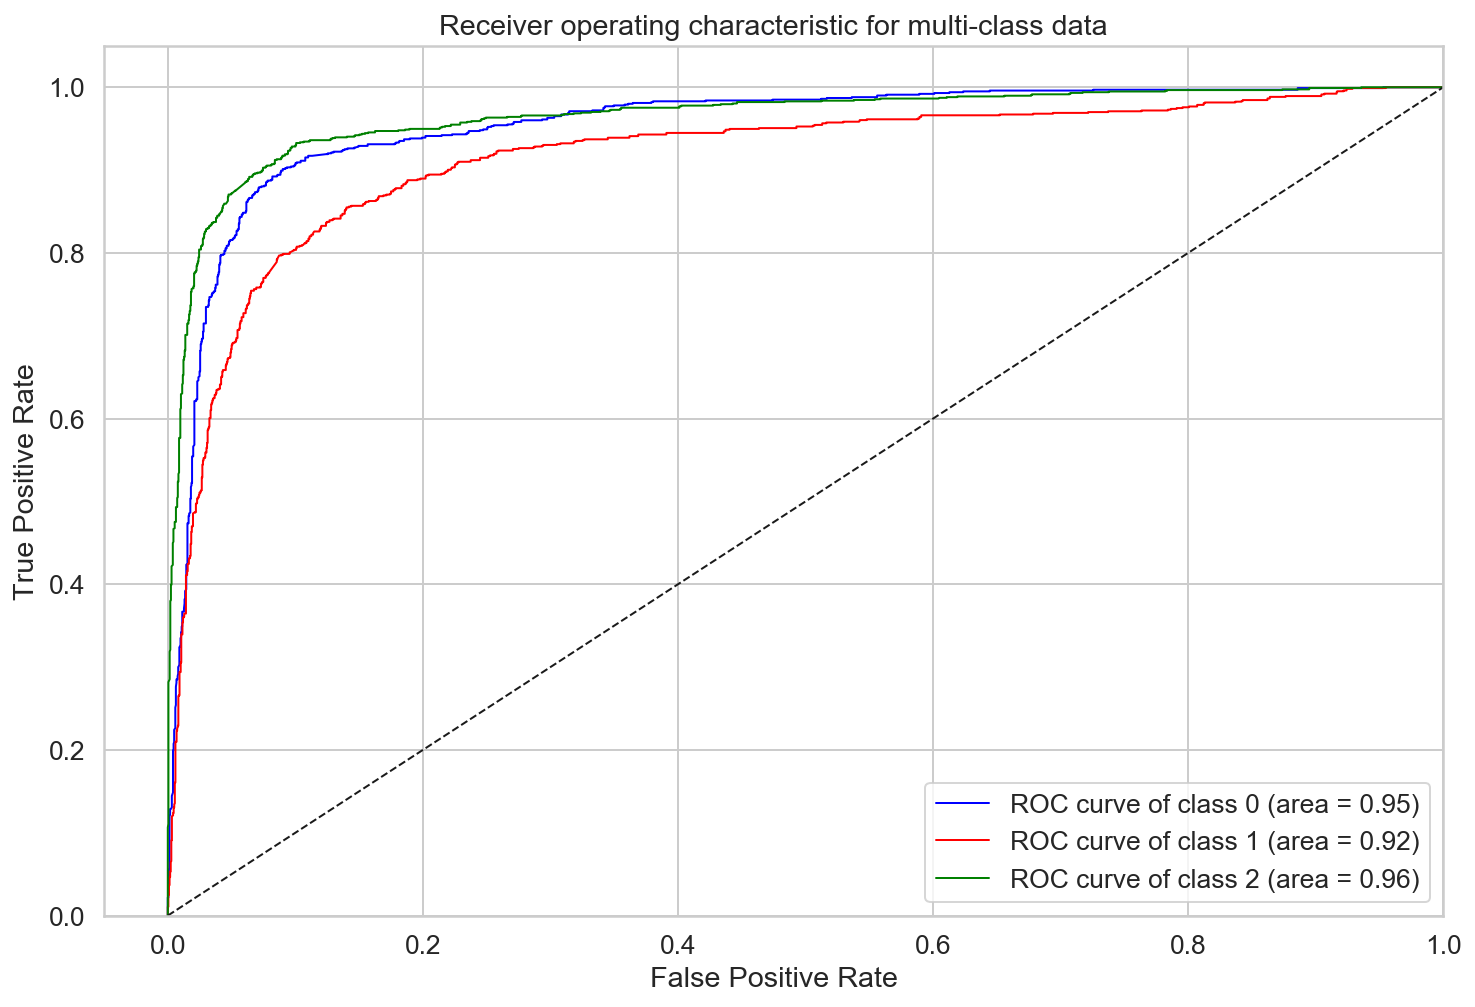

In [82]:
# actual_list = []
# pred = []
# pred_prob = []
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], np.array(pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()